## Compromise Detection System

## Problem Statement

The exponential growth of network traffic has led to an increase in network anomalies, such as cyber attacks, network failures, and hardware malfunctions. Compromise detection is a critical task for maintaining the security and stability of computer networks as well as indetifying anamolies. The objective of our project is  helps to understand how K-Means can be used for Compromise detection.

**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, kmeans_plusplus
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = [10, 6]

%load_ext autotime

time: 0 ns (started: 2024-04-07 22:27:45 +05:30)


**Utility Functions**

In [2]:
def nth_max(X, n):
    return np.partition(X.flatten(), -n)[-n]

time: 0 ns (started: 2024-04-07 22:27:45 +05:30)


In [3]:
def np_value_counts(ndarray):
    unique, counts = np.unique(ndarray, return_counts=True)
    return np.asarray((unique, counts)).T

time: 0 ns (started: 2024-04-07 22:27:45 +05:30)


## 1. Download the Datset

For this Project, we will use the ”KDD Cup 1999” dataset, which is a widely used benchmark dataset for  Compromise detection. The data is available at the following [link](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). 

In [4]:
with open('data/kddcup.names') as file:
    lines = [line.rstrip() for line in file]
columns = [line.split(":")[0] for line in lines[1:]]
columns.append('label')

time: 0 ns (started: 2024-04-07 22:27:45 +05:30)


In [5]:
presaved_files = os.path.isfile('train.gz') and os.path.isfile('train10.gz') and os.path.isfile('test.gz')
presaved_files

True

time: 15 ms (started: 2024-04-07 22:27:45 +05:30)


In [6]:
if presaved_files:
    train = pd.read_csv('train.gz', compression='gzip')
    train10 = pd.read_csv('train10.gz', compression='gzip')
    test = pd.read_csv('test.gz', compression='gzip')

time: 1min 7s (started: 2024-04-07 22:27:45 +05:30)


In [7]:
if not presaved_files:
    train = pd.read_csv('data/kddcup.data.gz', compression='gzip', names=columns)
train

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,215,45076,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,162,4528,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,236,1228,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,233,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,212,2288,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898427,0,219,236,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898428,0,218,3610,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898429,0,219,1234,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


time: 1.12 s (started: 2024-04-07 22:28:52 +05:30)


In [8]:
if not presaved_files:
    train10 = pd.read_csv('data/kddcup.data_10_percent.gz', compression='gzip', names=columns)
train10

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,235,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,219,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,217,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,310,1881,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
494017,0,282,2286,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
494018,0,203,1200,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
494019,0,291,1200,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


time: 281 ms (started: 2024-04-07 22:28:53 +05:30)


In [9]:
if not presaved_files:
    test = pd.read_csv('data/corrected.gz', compression='gzip', names=columns)
test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,105,146,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,105,146,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,105,146,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,105,146,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,0,105,146,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,105,147,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
311025,0,105,147,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
311026,0,105,147,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
311027,0,105,147,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


time: 156 ms (started: 2024-04-07 22:28:54 +05:30)


**One-Hot Encoding Categorical Columns**

In [10]:
def one_hot_encode_df(df1, df2, df3, columns_to_encode):
    dataframes = [df1, df2, df3]

    # Concatenate the DataFrames vertically
    concatenated_df = pd.concat(dataframes)

    # Perform one-hot encoding on the concatenated DataFrame
    encoded_df = pd.get_dummies(concatenated_df, columns=columns_to_encode)

    # Split the encoded DataFrame back into the original three DataFrames
    df1_encoded = encoded_df[:len(df1)]
    df2_encoded = encoded_df[len(df1):len(df1)+len(df2)]
    df3_encoded = encoded_df[len(df1)+len(df2):]

    return df1_encoded, df2_encoded, df3_encoded

time: 0 ns (started: 2024-04-07 22:28:54 +05:30)


In [11]:
if not presaved_files:
    train, train10, test = one_hot_encode_df(train, train10, test, ['protocol_type', 'service', 'flag'])

time: 16 ms (started: 2024-04-07 22:28:54 +05:30)


**Label encode labels**

In [12]:
if not presaved_files:
    le = preprocessing.LabelEncoder()
    le.fit(pd.concat([train['label'], test['label']], axis=0))
    le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    train.replace({'label': le_mapping}, inplace=True)
    train10.replace({'label': le_mapping}, inplace=True)
    test.replace({'label': le_mapping}, inplace=True)

time: 0 ns (started: 2024-04-07 22:28:54 +05:30)


**Save Processed Data for Later Runs**

In [13]:
train.iloc[:-1]

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,215,45076,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,162,4528,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,236,1228,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,233,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898425,0,219,244,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898426,0,212,2288,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898427,0,219,236,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898428,0,218,3610,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


time: 1.14 s (started: 2024-04-07 22:28:54 +05:30)


In [14]:
if not presaved_files:
    train.to_csv("train.gz", index=False, compression="gzip")
    train10.to_csv("train10.gz", index=False, compression="gzip")
    test.to_csv("test.gz", index=False, compression="gzip")
    
    presaved_files = True

time: 0 ns (started: 2024-04-07 22:28:55 +05:30)


**Dropping the label column**

In [15]:

train_label = train.loc[:, 'label']
train.drop(['label'], axis=1, inplace=True)

time: 766 ms (started: 2024-04-07 22:28:55 +05:30)


In [16]:
train10_label = train10.loc[:, 'label']
train10.drop(['label'], axis=1, inplace=True)

time: 125 ms (started: 2024-04-07 22:28:56 +05:30)


In [17]:
test_label = test.loc[:, 'label']
test.drop(['label'], axis=1, inplace=True)

time: 62 ms (started: 2024-04-07 22:28:56 +05:30)


**Dataset Analysis**

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Columns: 123 entries, duration to flag_SH
dtypes: bool(85), float64(15), int64(23)
memory usage: 1.8 GB
time: 16 ms (started: 2024-04-07 22:28:56 +05:30)


In [19]:
train10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Columns: 123 entries, duration to flag_SH
dtypes: bool(85), float64(15), int64(23)
memory usage: 183.3 MB
time: 16 ms (started: 2024-04-07 22:28:56 +05:30)


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311029 entries, 0 to 311028
Columns: 123 entries, duration to flag_SH
dtypes: bool(85), float64(15), int64(23)
memory usage: 115.4 MB
time: 16 ms (started: 2024-04-07 22:28:56 +05:30)


In [21]:
train.nunique()

duration           9883
src_bytes          7195
dst_bytes         21493
land                  2
wrong_fragment        3
                  ...  
flag_S1               2
flag_S2               2
flag_S3               2
flag_SF               2
flag_SH               2
Length: 123, dtype: int64

time: 5.25 s (started: 2024-04-07 22:28:56 +05:30)


In [22]:
train10.nunique()

duration           2495
src_bytes          3300
dst_bytes         10725
land                  2
wrong_fragment        3
                  ...  
flag_S1               2
flag_S2               2
flag_S3               2
flag_SF               2
flag_SH               2
Length: 123, dtype: int64

time: 562 ms (started: 2024-04-07 22:29:01 +05:30)


In [23]:
test.nunique()

duration           745
src_bytes         2504
dst_bytes         9202
land                 2
wrong_fragment       3
                  ... 
flag_S1              2
flag_S2              2
flag_S3              2
flag_SF              2
flag_SH              2
Length: 123, dtype: int64

time: 391 ms (started: 2024-04-07 22:29:02 +05:30)


**Removing `num_outbound_cmds` column from dataset as it has only one value**

In [24]:
train.drop(columns=['num_outbound_cmds'], inplace=True)

time: 1 s (started: 2024-04-07 22:29:02 +05:30)


In [25]:
train10.drop(columns=['num_outbound_cmds'], inplace=True)

time: 109 ms (started: 2024-04-07 22:29:03 +05:30)


In [26]:
test.drop(columns=['num_outbound_cmds'], inplace=True)

time: 78 ms (started: 2024-04-07 22:29:03 +05:30)


**Converting to NumPy arrays**

In [27]:
x_train = train.to_numpy().astype('float32')
y_train = train_label.to_numpy().astype('uint8')

x_train10 = train10.to_numpy().astype('float32')
y_train10 = train10_label.to_numpy().astype('uint8')

x_test = test.to_numpy().astype('float32')
y_test = test_label.to_numpy().astype('uint8')

time: 1min 15s (started: 2024-04-07 22:29:04 +05:30)


**Running PCA on dataset to reduce dimensionality**

In [28]:
pca = PCA()
pca.fit(x_train)

# Calculate the number of components based on the desired variance ratio
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
n_components = len(explained_variance_ratio_cumsum[explained_variance_ratio_cumsum < 0.9999]) + 1
n_components

2

time: 1min 8s (started: 2024-04-07 22:30:19 +05:30)


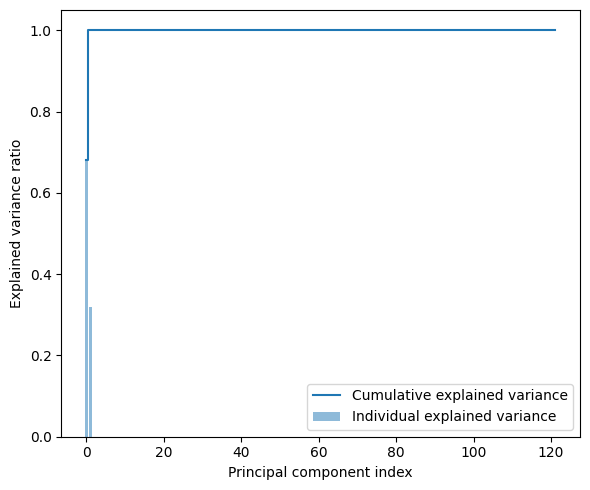

time: 859 ms (started: 2024-04-07 22:31:28 +05:30)


In [29]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.figure(figsize=(6,5))
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
x_train = pca.transform(x_train)[:, :n_components]

time: 4.02 s (started: 2024-04-07 22:31:29 +05:30)


In [31]:
x_train10 = pca.transform(x_train10)[:, :n_components]

time: 453 ms (started: 2024-04-07 22:31:33 +05:30)


In [32]:
x_test = pca.transform(x_test)[:, :n_components]

time: 282 ms (started: 2024-04-07 22:31:33 +05:30)


**Finalized Dataset**

In [33]:
x_train

array([[-1.6060270e+03,  4.3982867e+04],
       [-1.6715608e+03,  3.4348926e+03],
       [-1.5985808e+03,  1.3487032e+02],
       ...,
       [-1.6158446e+03,  2.5168752e+03],
       [-1.6155791e+03,  1.4087549e+02],
       [-1.6156211e+03,  4.8755445e+00]], dtype=float32)

time: 15 ms (started: 2024-04-07 22:31:34 +05:30)


In [34]:
y_train

array([16, 16, 16, ..., 16, 16, 16], dtype=uint8)

time: 0 ns (started: 2024-04-07 22:31:34 +05:30)


In [35]:
x_train10

array([[-1652.2758  ,  4356.8867  ],
       [-1595.8102  ,  -607.1305  ],
       [-1599.5471  ,   243.87059 ],
       ...,
       [-1631.5896  ,   106.88045 ],
       [-1543.5896  ,   106.853264],
       [-1615.5791  ,   140.87549 ]], dtype=float32)

time: 0 ns (started: 2024-04-07 22:31:34 +05:30)


In [36]:
y_train10

array([16, 16, 16, ..., 16, 16, 16], dtype=uint8)

time: 15 ms (started: 2024-04-07 22:31:34 +05:30)


In [37]:
x_test

array([[-1729.9153 ,  -947.08905],
       [-1729.9153 ,  -947.08905],
       [-1729.9153 ,  -947.08905],
       ...,
       [-1729.915  ,  -946.08905],
       [-1729.915  ,  -946.08905],
       [-1729.915  ,  -946.08905]], dtype=float32)

time: 16 ms (started: 2024-04-07 22:31:34 +05:30)


In [38]:
y_test

array([16, 16, 16, ..., 16, 16, 16], dtype=uint8)

time: 0 ns (started: 2024-04-07 22:31:34 +05:30)


## 2. Clustering Using K-Means 

We will use K-Means to cluster the network traffic data and identify anomalies. Every data traffic is a feature vector of 41 dimension. We will use this feature representation to do the clustering.

• We will change the K of the K-means algorithm between {7, 15, 23, 31,45} clusters. We will produce different clusters.

In [39]:
def k_means_clustering(X, k, epsilon=1e-6, num_iters=100):
    # Initialize k centroids using k-means++
    centroids, _ = kmeans_plusplus(X, n_clusters=k)
    
    old_centroids = np.copy(centroids)
    for t in range(num_iters):
        clusters = [set() for i in range(k)]
        
        # Cluster Assignment Step
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
    
        # Centroid Update Step
        for i in range(k):
            clusters[i] = np.where(labels==i)[0]
            if len(clusters[i]) == 0:
                centroids[i] = None
            else:
                centroids[i] = np.mean(X[clusters[i]], axis=0)

        if np.linalg.norm(centroids - old_centroids) <= epsilon:
            labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
            return labels, centroids
        else:
            old_centroids = np.copy(centroids)
    
    labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
    return labels, centroids

time: 0 ns (started: 2024-04-07 22:31:34 +05:30)


In [40]:
def k_means_test(x_test, centroids):
    return np.argmin(np.linalg.norm(x_test[:, np.newaxis] - centroids, axis=2), axis=1)

time: 0 ns (started: 2024-04-07 22:31:34 +05:30)


In [41]:
results = dict()
for k in [7, 15, 23, 31,45]:
    print(f"@ k = {k}")
    labels, centroids = k_means_clustering(x_train10, k)
    
    results[k] = dict()
    results[k]['labels'] = labels
    results[k]['centroids'] = centroids
    results[k]['y_pred'] = k_means_test(x_test, centroids)

@ k = 7
@ k = 15
@ k = 23
@ k = 31
@ k = 45
time: 1min 25s (started: 2024-04-07 22:31:34 +05:30)


In [42]:
results

{7: {'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  'centroids': array([[-9.3013330e+02, -5.2178619e+02],
         [ 6.9337370e+08, -2.1531884e+05],
         [ 5.1323920e+06, -2.6792153e+03],
         [-1.7745477e+02,  5.0085965e+06],
         [ 2.2017508e+06, -1.7738759e+03],
         [-7.2804974e+02,  1.7937111e+06],
         [-9.7140088e+02,  6.1341625e+05]], dtype=float32),
  'y_pred': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)},
 15: {'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  'centroids': array([[-1.1916902e+03, -9.2278259e+02],
         [ 6.9337370e+08, -2.1531884e+05],
         [ 5.1323920e+06, -2.6792153e+03],
         [-2.4291745e+02,  5.1492875e+06],
         [ 2.2017508e+06, -1.7738759e+03],
         [-8.6595563e+02,  1.5140224e+06],
         [-9.2059064e+02,  5.5393825e+05],
         [ 5.3974176e+04,  6.6989497e+03],
         [-3.9707529e+02,  2.4649648e+06],
         [ 3.4624658e+02,  3.8830670e+06],
         [-1.5491558e+03,  1.0449436e+04],
    

time: 15 ms (started: 2024-04-07 22:32:59 +05:30)


**K-Means Clustering Results Count**

In [43]:
np_value_counts(results[23]['labels'])

array([[     0, 172811],
       [     1,      1],
       [     2,     59],
       [     3,     16],
       [     4,     24],
       [     5,     12],
       [     6,     13],
       [     7,   2308],
       [     8,      5],
       [     9,   1835],
       [    10,      2],
       [    11,      8],
       [    12,     35],
       [    13,     13],
       [    14,   6158],
       [    15,    499],
       [    16,      7],
       [    17,     21],
       [    18,     97],
       [    19, 292056],
       [    20,     34],
       [    21,  16777],
       [    22,   1230]], dtype=int64)

time: 16 ms (started: 2024-04-07 22:32:59 +05:30)


## 3. Evaluation

We will evaluate models based on their ability to detect network anomalies accurately. You will be required to use the following metrics to evaluate the quality of their models:

• Precision (is the ratio of correctly predicted positive observations to the total predicted positives. It measures the accuracy of the positive predictions.)

• Recall (also known as sensitivity or true positive rate, is the ratio of correctly predicted positive observations to all actual positives. It measures the model's ability to find all positive instances. )

• F1 score ( is the harmonic mean of precision and recall. It provides a balance between precision and recall.)

• Conditional Entropy

**Running K-Means on `x_train` for evaluation purposes**

In [44]:
km_results = dict()
for k in [7, 15, 23, 31,45]:
    print(f"@ k = {k}")
    labels, centroids = k_means_clustering(x_train, k)
    
    km_results[k] = dict()
    km_results[k]['labels'] = labels
    km_results[k]['centroids'] = centroids
    km_results[k]['y_pred'] = k_means_test(x_test, centroids)

@ k = 7


@ k = 15
@ k = 23
@ k = 31
@ k = 45
time: 13min 4s (started: 2024-04-07 22:32:59 +05:30)


### Precision

In [66]:
def precision_per_cluster(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    return np.max(cont_mat, axis=1) / np.sum(cont_mat, axis=1)

time: 0 ns (started: 2024-04-07 22:52:56 +05:30)


In [67]:
def overall_precision(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    p_per_c = precision_per_cluster(y_true, y_pred)
    return np.sum(np.multiply(np.sum(cont_mat, axis=1) / np.sum(cont_mat), p_per_c))

time: 0 ns (started: 2024-04-07 22:52:58 +05:30)


**K-Means Clustering**

In [68]:
for k in [7, 15, 23, 31,45]:
    print(f"@ k = {k}:\t{overall_precision(y_train, km_results[k]['labels'])}")


@ k = 7:	0.5732233443729225

@ k = 15:	0.5733248054325963

@ k = 23:	0.5814394445895021

@ k = 31:	0.5961076107839428

@ k = 45:	0.6383954372328609
time: 4.55 s (started: 2024-04-07 22:53:01 +05:30)


### Recall

In [48]:
def recall_per_cluster(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    partition_fraction = np.sum(cont_mat[:, np.argmax(cont_mat, axis=1)], axis=0)
    return np.max(cont_mat, axis=1) / partition_fraction

time: 0 ns (started: 2024-04-07 22:46:10 +05:30)


In [49]:
def overall_recall(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    r_per_c = recall_per_cluster(y_true, y_pred)
#     partition_fraction = np.sum(cont_mat[:, np.argmax(cont_mat, axis=1)], axis=0)
#     return np.sum(np.multiply(partition_fraction / np.sum(cont_mat), r_per_c))
    return np.sum(np.multiply(np.sum(cont_mat, axis=1) / np.sum(cont_mat), r_per_c))

time: 0 ns (started: 2024-04-07 22:46:10 +05:30)


**K-Means Clustering**

In [50]:
for k in [7, 15, 23, 31,45]:
    print(f"@ k = {k}:\t{overall_recall(y_train, km_results[k]['labels'])}")

@ k = 7:	0.9999981629710629
@ k = 15:	0.9998920014497829
@ k = 23:	0.992100020253613
@ k = 31:	0.9795334719809443
@ k = 45:	0.9443793921073439
time: 5.01 s (started: 2024-04-07 22:46:10 +05:30)


### F1 Score

In [51]:
def overall_f1_score(y_true, y_pred):
    p_per_c = precision_per_cluster(y_true, y_pred)
    r_per_c = recall_per_cluster(y_true, y_pred)
    return np.mean(2 * np.multiply(p_per_c, r_per_c) / (p_per_c + r_per_c))

time: 0 ns (started: 2024-04-07 22:46:15 +05:30)


**K-Means Clustering**

In [52]:
for k in [7, 15, 23, 31,45]:
    print(f"@ k = {k}:\t{overall_f1_score(y_train, km_results[k]['labels'])}")

@ k = 7:	0.10435034070252809
@ k = 15:	0.0559971983843178
@ k = 23:	0.06787116377239559
@ k = 31:	0.08170137813942757
@ k = 45:	0.06624648783267638
time: 4.5 s (started: 2024-04-07 22:46:15 +05:30)


### Conditional Entropy

In [53]:
def entropy(x):
    with np.errstate(all='ignore'):
        return np.nan_to_num(-x * np.log(x))

time: 0 ns (started: 2024-04-07 22:46:19 +05:30)


In [54]:
def conditional_entropy(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    n = np.sum(cont_mat)
    p_ci = np.sum(cont_mat, axis=1) / n
    p_ij = cont_mat / np.sum(cont_mat, axis=1)[:, np.newaxis]
    H_T_Ci = np.sum(entropy(p_ij), axis=1)
    return np.sum(np.multiply(p_ci, H_T_Ci))

time: 0 ns (started: 2024-04-07 22:46:19 +05:30)


**K-Means Clustering**

In [55]:
for k in [7, 15, 23, 31,45]:
    print(f"@ k = {k}:\t{conditional_entropy(y_train, km_results[k]['labels']):.3f}\t(worst = {np.log(k):.3f})")

@ k = 7:	1.031	(worst = 1.946)
@ k = 15:	1.031	(worst = 2.708)
@ k = 23:	1.017	(worst = 3.135)
@ k = 31:	0.990	(worst = 3.434)
@ k = 45:	0.912	(worst = 3.807)
time: 2.31 s (started: 2024-04-07 22:46:19 +05:30)


## 4. DBSCAN


### DBSCAN (Density-based spatial clustering of applications with noise)

In [56]:
def dbscan(X, epsilon, min_pts):
    # Calculate pairwise distances between all samples
    dists = cdist(X, X)

    # Initialize labels and cluster ID
    labels = np.full(X.shape[0], -1)
    cluster_id = 0

    # Loop over all samples
    for i in range(X.shape[0]):
        if labels[i] != -1:
            # Sample already assigned to a cluster
            continue

        # Find all samples within epsilon distance from current sample
        neighbors = np.where(dists[i] <= epsilon)[0]

        if len(neighbors) < min_pts:
            # Sample is noise
            labels[i] = 0
            continue

        # Expand the cluster starting from the current sample
        cluster_id += 1
        labels[i] = cluster_id

        # Loop over all neighbors
        for j in neighbors:
            if labels[j] == -1:
                # Neighbor not yet assigned to a cluster
                labels[j] = cluster_id

                # Find all samples within epsilon distance from this neighbor
                new_neighbors = np.where(dists[j] <= epsilon)[0]

                if len(new_neighbors) >= min_pts:
                    # Neighbor is a core point, expand the cluster from this point
                    neighbors = np.concatenate([neighbors, new_neighbors])

            elif labels[j] == 0:
                # Neighbor previously identified as noise, add to current cluster
                labels[j] = cluster_id

    return labels

time: 16 ms (started: 2024-04-07 22:46:22 +05:30)


In [57]:
x_subset = x_train[:1000]
dbscan_labels= dbscan( x_subset,1, 40)

time: 15 ms (started: 2024-04-07 22:46:22 +05:30)


In [58]:
num_clusters = len(np.unique(dbscan_labels))
num_clusters

1

time: 0 ns (started: 2024-04-07 22:46:22 +05:30)


**Precision**

In [59]:
overall_precision(x_subset, dbscan_labels)

ValueError: row, column, and data array must all be the same length

time: 1.61 s (started: 2024-04-07 22:46:22 +05:30)


**Recall**

In [71]:
overall_recall(y_train, dbscan_labels)

ValueError: row, column, and data array must all be the same length

time: 578 ms (started: 2024-04-08 00:10:22 +05:30)


**F1 Score**

In [ ]:
overall_f1_score(y_train, dbscan_labels)

NameError: name 'overall_f1_score' is not defined

**Conditional Entropy**

In [72]:
print(f"{conditional_entropy(y_train, dbscan_labels):.3f}\t(worst = {np.log(len(np.unique(dbscan_labels))):.3f})")

ValueError: row, column, and data array must all be the same length

time: 531 ms (started: 2024-04-08 00:10:27 +05:30)


## Displaying Plots

In [69]:
def display_plot(X, labels, plot_style, title=''):
    fig = plt.figure(figsize=(6,6))
    if plot_style == '2d':
        ax = fig.add_subplot(111)
        ax.scatter(X[:,0], X[:,1], c=labels, lw=0)
    elif plot_style == '3d':
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], labels, c=labels, lw=0)
        ax.set_zlabel('k-th cluster')        
    
    plt.title(title)
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')

time: 0 ns (started: 2024-04-07 23:41:58 +05:30)


### K-Means

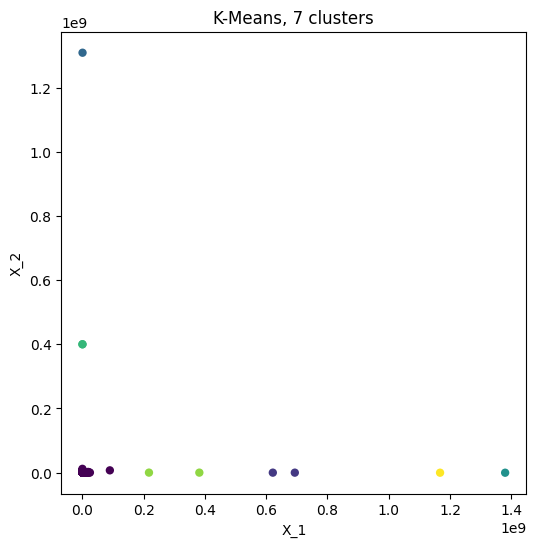

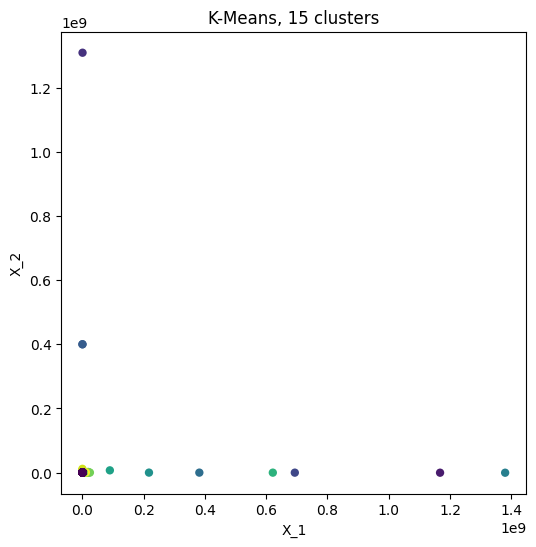

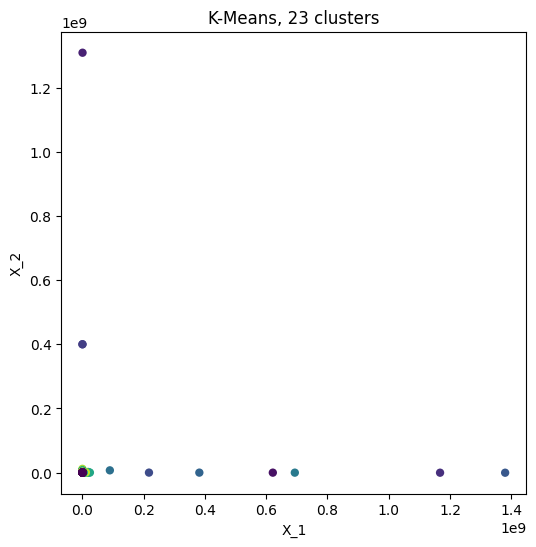

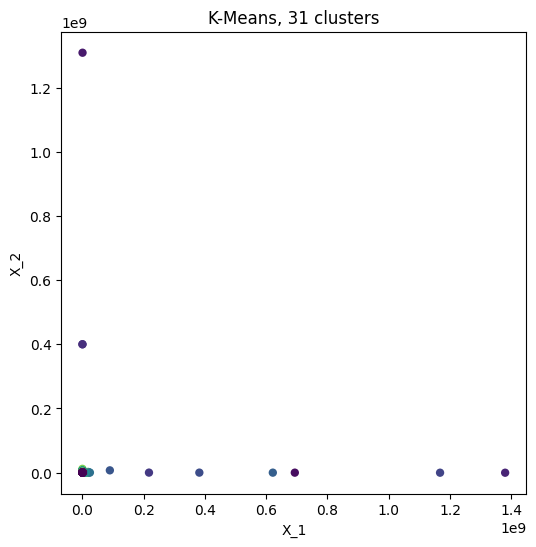

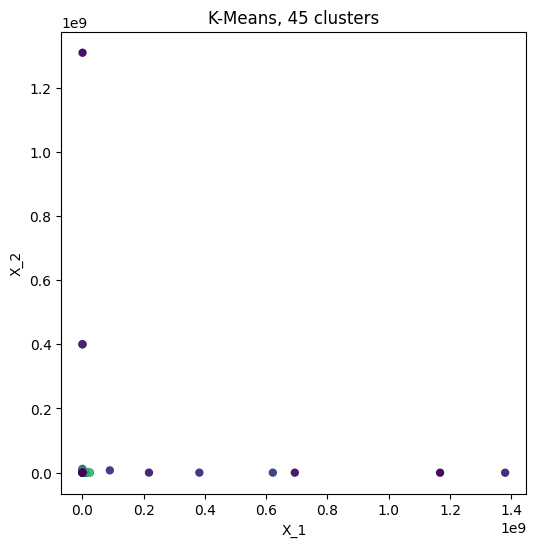

time: 4min 54s (started: 2024-04-07 23:42:00 +05:30)


In [70]:
for k in [7, 15, 23, 31,45]:
    display_plot(x_train, km_results[k]['labels'], '2d', title=f"K-Means, {k} clusters")